# EDA-11: ML Forecasting & Regional Analysis
## Trend Forecasting and Regional Growth Identification

This notebook performs advanced ML forecasting and identifies regions with rapid green energy growth.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Processed Data

In [3]:
# Load the preprocessed datasets
df_clean = pd.read_csv('../data/renewable_energy_clean1.csv')
df_ml = pd.read_csv('../data/renewable_energy_ml_features1.csv')

print(f"Clean dataset shape: {df_clean.shape}")
print(f"ML features dataset shape: {df_ml.shape}")
print(f"\nYears available: {sorted(df_clean['Year'].unique())}")

Clean dataset shape: (22669, 7)
ML features dataset shape: (20829, 12)

Years available: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


## 2. Global Trend Forecasting (Time Series)

In [4]:
# Aggregate global capacity by year
global_ts = df_clean.groupby('Year')['Electricity Installed Capacity (MW)'].sum().reset_index()
global_ts = global_ts.sort_values('Year').reset_index(drop=True)

# Linear Regression Model for Trend
X = global_ts[['Year']].values
y = global_ts['Electricity Installed Capacity (MW)'].values

# Split data
train_size = int(len(global_ts) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Model Evaluation
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_lr = mean_absolute_error(y_test, y_pred_test)
r2_lr = r2_score(y_test, y_pred_test)

print("="*80)
print("LINEAR REGRESSION MODEL - GLOBAL CAPACITY FORECAST")
print("="*80)
print(f"RMSE: {rmse_lr:,.2f} MW")
print(f"MAE: {mae_lr:,.2f} MW")
print(f"R² Score: {r2_lr:.4f}")
print(f"Trend Coefficient: {lr_model.coef_[0]:,.2f} MW/Year")

LINEAR REGRESSION MODEL - GLOBAL CAPACITY FORECAST
RMSE: 857,639.42 MW
MAE: 788,742.42 MW
R² Score: -2.5285
Trend Coefficient: 85,785.06 MW/Year


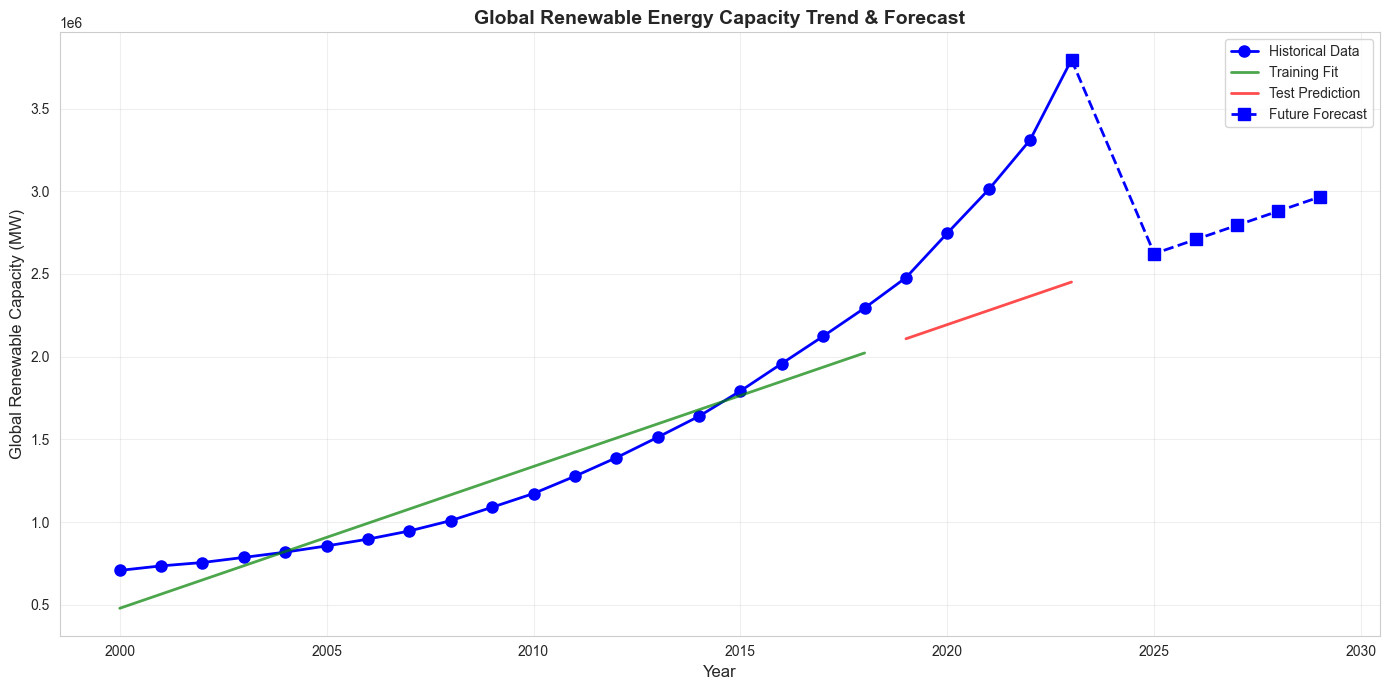


5-YEAR FORECAST (2025-2029)
Year 2025: 2,622,947 MW
Year 2026: 2,708,732 MW
Year 2027: 2,794,517 MW
Year 2028: 2,880,302 MW
Year 2029: 2,966,087 MW


In [5]:
# Forecast next 5 years
future_years = np.array([[2025], [2026], [2027], [2028], [2029]])
future_pred = lr_model.predict(future_years)

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data
ax.plot(global_ts['Year'], y, 'bo-', label='Historical Data', markersize=8, linewidth=2)

# Training prediction
ax.plot(X_train, y_pred_train, 'g-', alpha=0.7, label='Training Fit', linewidth=2)

# Test prediction
ax.plot(X_test, y_pred_test, 'r-', alpha=0.7, label='Test Prediction', linewidth=2)

# Future forecast
forecast_years = np.concatenate([[global_ts['Year'].max()], future_years.flatten()])
forecast_values = np.concatenate([[y[-1]], future_pred])
ax.plot(forecast_years, forecast_values, 'bs--', label='Future Forecast', markersize=8, linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Global Renewable Capacity (MW)', fontsize=12)
ax.set_title('Global Renewable Energy Capacity Trend & Forecast', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/global_forecast_linear.png', dpi=300, bbox_inches='tight')
plt.show()

# Print forecast
print("\n" + "="*80)
print("5-YEAR FORECAST (2025-2029)")
print("="*80)
for year, capacity in zip(future_years.flatten(), future_pred):
    print(f"Year {int(year)}: {capacity:,.0f} MW")

## 3. Random Forest & Gradient Boosting Models

In [13]:
# Prepare data for ensemble models
df_ml_data = df_ml.copy()

# Encode categorical variables
le_country = LabelEncoder()
le_tech = LabelEncoder()

df_ml_data['Country_Encoded'] = le_country.fit_transform(df_ml_data['Country'])
df_ml_data['Technology_Encoded'] = le_tech.fit_transform(df_ml_data['Technology'])

# Select ONLY numeric features
feature_cols = [
    'Year',
    'Country_Encoded',
    'Technology_Encoded',
    'Capacity_Lag1',
    'Capacity_Lag2',
    'Regional_Avg_Capacity'
]

# ✅ FIX HERE
X_ml = df_ml_data[feature_cols]
y_ml = df_ml_data['Electricity Installed Capacity (MW)']

# Split data
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ml)
X_test_scaled = scaler.transform(X_test_ml)

# Random Forest Model
print("Training Random Forest Model...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train_ml)

# Predictions
y_pred_rf_test = rf_model.predict(X_test_scaled)

# Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test_ml, y_pred_rf_test))
mae_rf = mean_absolute_error(y_test_ml, y_pred_rf_test)
r2_rf = r2_score(y_test_ml, y_pred_rf_test)

print("\n" + "="*80)
print("RANDOM FOREST MODEL")
print("="*80)
print(f"RMSE: {rmse_rf:,.2f} MW")
print(f"MAE: {mae_rf:,.2f} MW")
print(f"R² Score: {r2_rf:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Training Random Forest Model...

RANDOM FOREST MODEL
RMSE: 1,692.50 MW
MAE: 162.97 MW
R² Score: 0.9725

Feature Importance:
                 Feature  Importance
4          Capacity_Lag2    0.983935
3          Capacity_Lag1    0.005716
5  Regional_Avg_Capacity    0.004518
0                   Year    0.002920
2     Technology_Encoded    0.001793
1        Country_Encoded    0.001117


In [14]:
# Gradient Boosting Model
print("\nTraining Gradient Boosting Model...")
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train_ml)

y_pred_gb_train = gb_model.predict(X_train_scaled)
y_pred_gb_test = gb_model.predict(X_test_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_test_ml, y_pred_gb_test))
mae_gb = mean_absolute_error(y_test_ml, y_pred_gb_test)
r2_gb = r2_score(y_test_ml, y_pred_gb_test)

print("\n" + "="*80)
print("GRADIENT BOOSTING MODEL")
print("="*80)
print(f"RMSE: {rmse_gb:,.2f} MW")
print(f"MAE: {mae_gb:,.2f} MW")
print(f"R² Score: {r2_gb:.4f}")

# Compare all models
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'RMSE (MW)': [rmse_lr, rmse_rf, rmse_gb],
    'MAE (MW)': [mae_lr, mae_rf, mae_gb],
    'R² Score': [r2_lr, r2_rf, r2_gb]
})
print(comparison_df.to_string(index=False))


Training Gradient Boosting Model...

GRADIENT BOOSTING MODEL
RMSE: 1,691.75 MW
MAE: 220.04 MW
R² Score: 0.9725

MODEL COMPARISON
            Model     RMSE (MW)      MAE (MW)  R² Score
Linear Regression 857639.416115 788742.417105 -2.528474
    Random Forest   1692.499453    162.969916  0.972477
Gradient Boosting   1691.747265    220.042382  0.972502


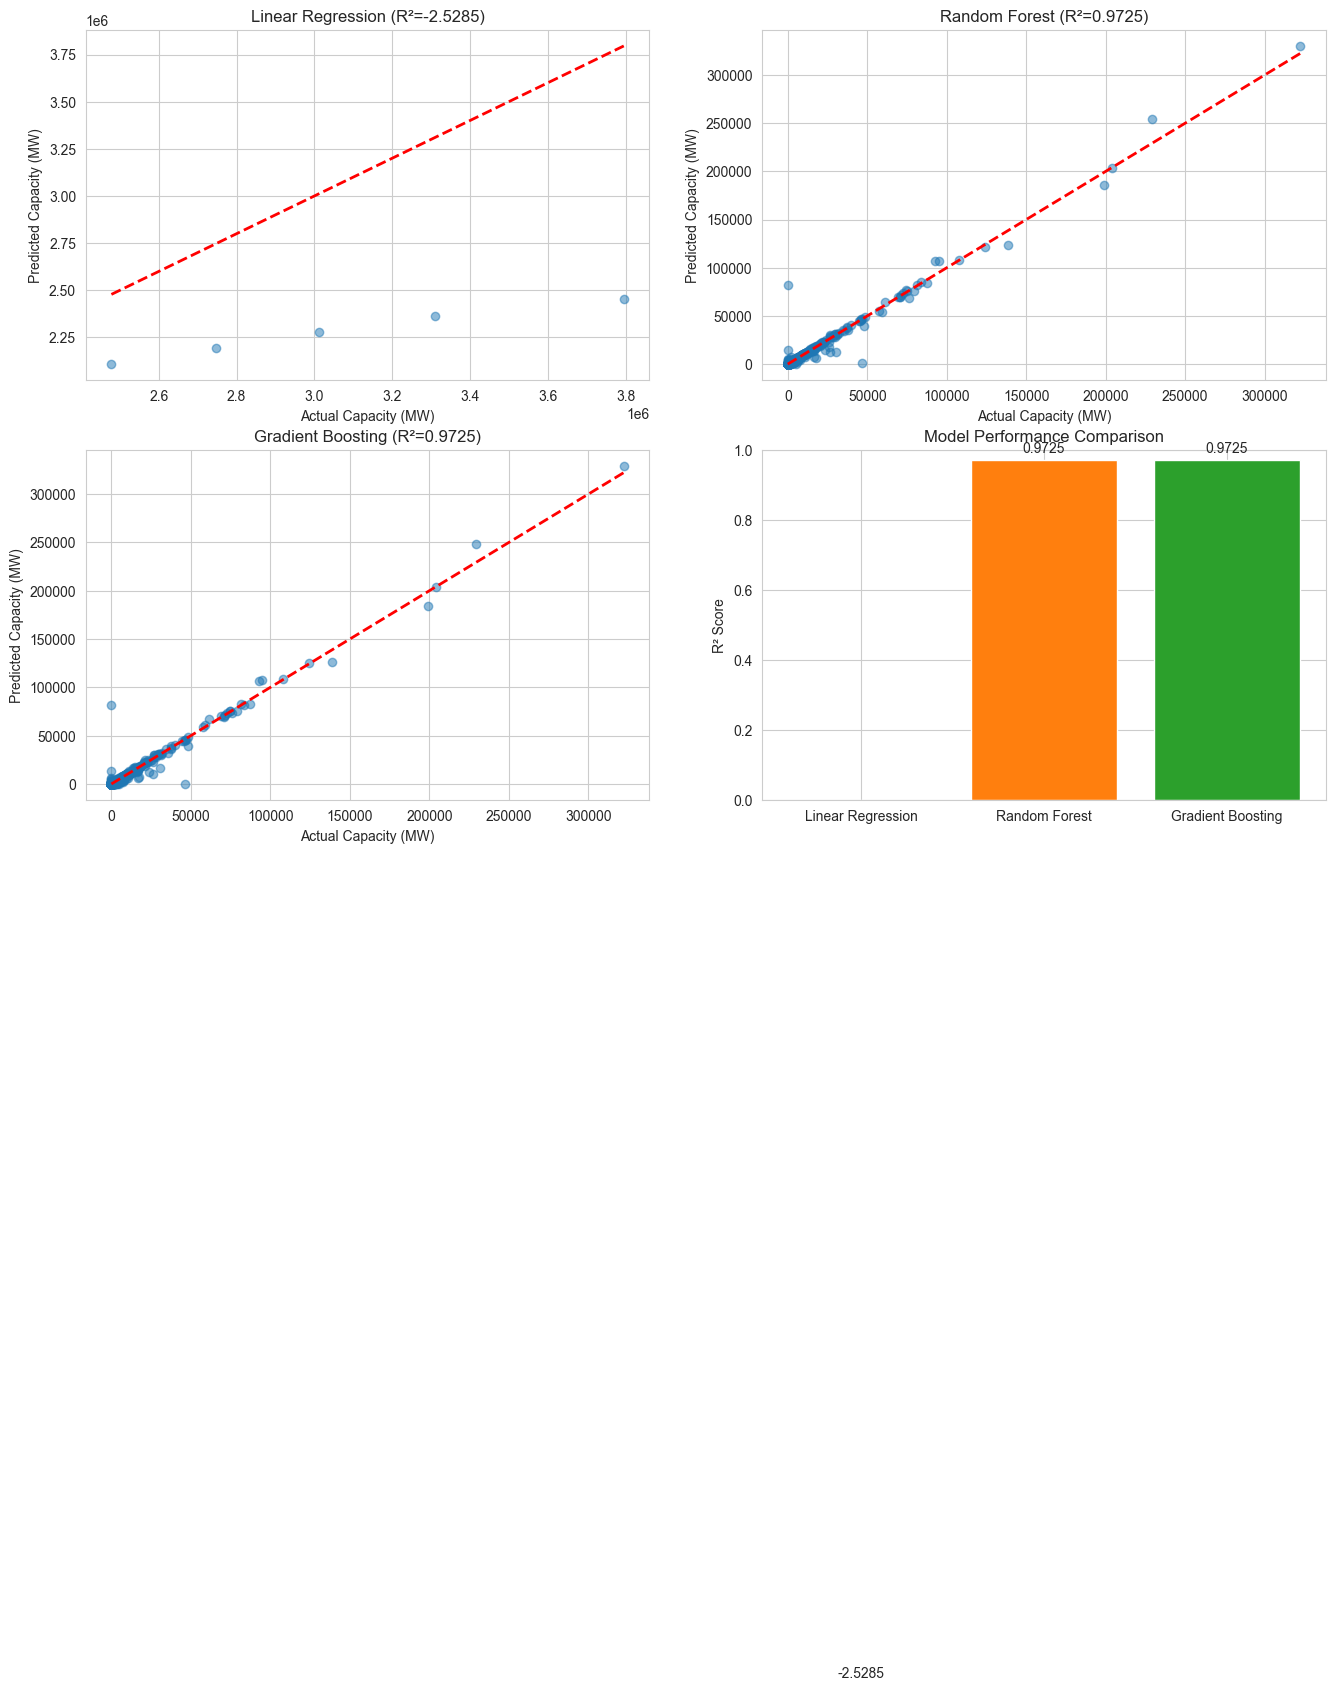

Model comparison visualization saved!


In [15]:
# Visualize Model Predictions vs Actual
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Actual vs Predicted - Linear Regression
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Capacity (MW)')
axes[0, 0].set_ylabel('Predicted Capacity (MW)')
axes[0, 0].set_title(f'Linear Regression (R²={r2_lr:.4f})')

# Actual vs Predicted - Random Forest
axes[0, 1].scatter(y_test_ml, y_pred_rf_test, alpha=0.5)
axes[0, 1].plot([y_test_ml.min(), y_test_ml.max()], [y_test_ml.min(), y_test_ml.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Capacity (MW)')
axes[0, 1].set_ylabel('Predicted Capacity (MW)')
axes[0, 1].set_title(f'Random Forest (R²={r2_rf:.4f})')

# Actual vs Predicted - Gradient Boosting
axes[1, 0].scatter(y_test_ml, y_pred_gb_test, alpha=0.5)
axes[1, 0].plot([y_test_ml.min(), y_test_ml.max()], [y_test_ml.min(), y_test_ml.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Capacity (MW)')
axes[1, 0].set_ylabel('Predicted Capacity (MW)')
axes[1, 0].set_title(f'Gradient Boosting (R²={r2_gb:.4f})')

# Model Comparison - Bar Chart
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
r2_scores = [r2_lr, r2_rf, r2_gb]
axes[1, 1].bar(models, r2_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(r2_scores):
    axes[1, 1].text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('../data/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved!")

## 4. Regional Growth Identification and Clustering

In [16]:
from sklearn.cluster import KMeans

# Calculate regional growth metrics
regional_metrics = []

for region in df_clean['Region'].unique():
    region_data = df_clean[df_clean['Region'] == region].groupby('Year')['Electricity Installed Capacity (MW)'].sum()
    
    min_year = region_data.index.min()
    max_year = region_data.index.max()
    
    if len(region_data) > 1:
        start_capacity = region_data[min_year]
        end_capacity = region_data[max_year]
        
        # CAGR
        years = max_year - min_year
        if start_capacity > 0:
            cagr = ((end_capacity / start_capacity) ** (1 / years) - 1) * 100
        else:
            cagr = 0
        
        # Average capacity
        avg_capacity = region_data.mean()
        
        # Latest capacity
        latest_capacity = region_data[max_year]
        
        regional_metrics.append({
            'Region': region,
            'CAGR': cagr,
            'Latest_Capacity': latest_capacity,
            'Average_Capacity': avg_capacity,
            'Growth_Multiple': end_capacity / start_capacity if start_capacity > 0 else 0
        })

metrics_df = pd.DataFrame(regional_metrics).sort_values('CAGR', ascending=False)

print("="*80)
print("REGIONAL GROWTH METRICS")
print("="*80)
print(metrics_df.to_string(index=False))

# Classify regions by growth
print("\n" + "="*80)
print("REGIONS CLASSIFIED BY GROWTH POTENTIAL")
print("="*80)

rapid_growth = metrics_df[metrics_df['CAGR'] > metrics_df['CAGR'].quantile(0.66)]['Region'].tolist()
steady_growth = metrics_df[(metrics_df['CAGR'] >= metrics_df['CAGR'].quantile(0.33)) & 
                           (metrics_df['CAGR'] <= metrics_df['CAGR'].quantile(0.66))]['Region'].tolist()
emerging = metrics_df[metrics_df['CAGR'] < metrics_df['CAGR'].quantile(0.33)]['Region'].tolist()

print(f"\n🚀 RAPID GROWTH REGIONS (Top 33%):")
for region in rapid_growth:
    cagr = metrics_df[metrics_df['Region'] == region]['CAGR'].values[0]
    print(f"  • {region}: {cagr:.2f}% CAGR")

print(f"\n📈 STEADY GROWTH REGIONS (Middle 33%):")
for region in steady_growth:
    cagr = metrics_df[metrics_df['Region'] == region]['CAGR'].values[0]
    print(f"  • {region}: {cagr:.2f}% CAGR")

print(f"\n🌱 EMERGING REGIONS (Bottom 33%):")
for region in emerging:
    cagr = metrics_df[metrics_df['Region'] == region]['CAGR'].values[0]
    print(f"  • {region}: {cagr:.2f}% CAGR")

REGIONAL GROWTH METRICS
  Region      CAGR  Latest_Capacity  Average_Capacity  Growth_Multiple
    Asia 11.023908      2057556.386     700042.882500        11.081021
 Oceania 10.248267        59770.562      24682.890333         9.430848
  Europe  6.082627       790918.498     411629.971083         3.888822
  Africa  4.939216        65164.342      33783.726458         3.030887
Americas  4.626956       822115.099     459030.560417         2.830105

REGIONS CLASSIFIED BY GROWTH POTENTIAL

🚀 RAPID GROWTH REGIONS (Top 33%):
  • Asia: 11.02% CAGR
  • Oceania: 10.25% CAGR

📈 STEADY GROWTH REGIONS (Middle 33%):
  • Europe: 6.08% CAGR

🌱 EMERGING REGIONS (Bottom 33%):
  • Africa: 4.94% CAGR
  • Americas: 4.63% CAGR


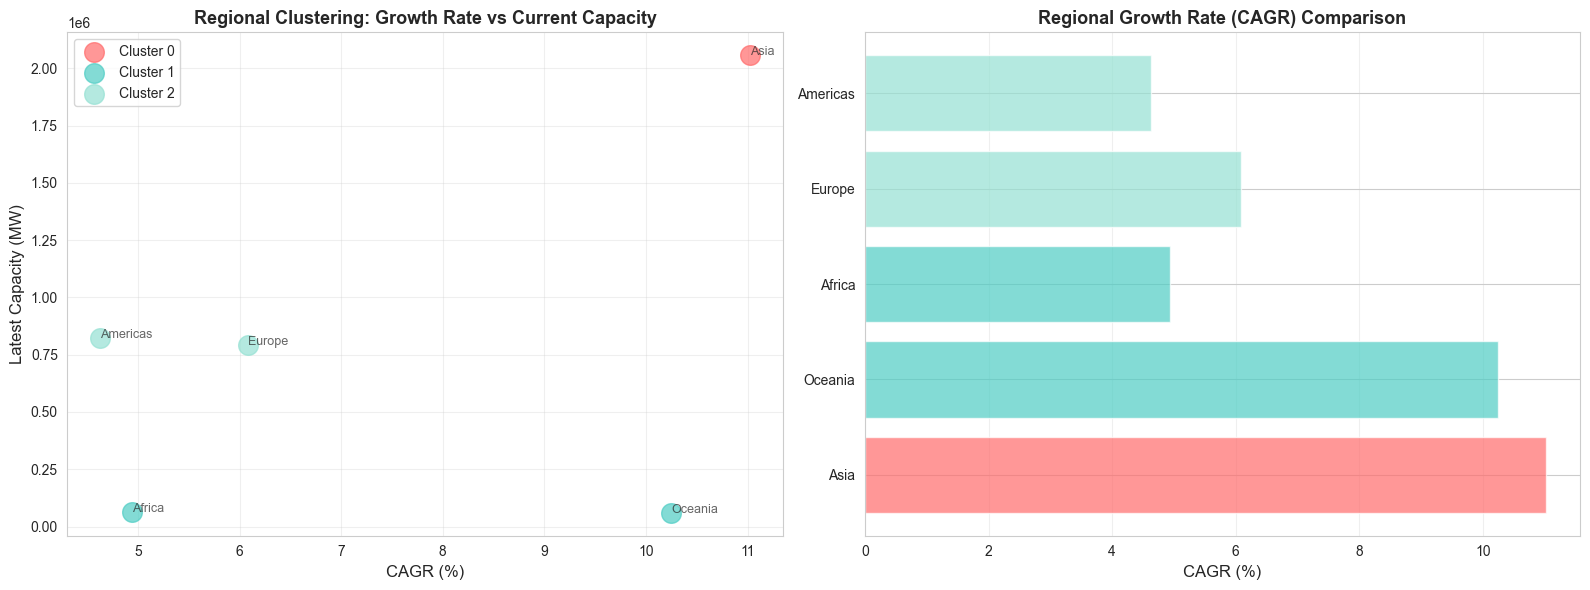

Regional clustering visualization saved!


In [17]:
# K-Means Clustering on regional features
X_cluster = metrics_df[['CAGR', 'Latest_Capacity', 'Average_Capacity']].values
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
metrics_df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Visualize regional clustering
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CAGR vs Latest Capacity
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
for cluster in metrics_df['Cluster'].unique():
    cluster_data = metrics_df[metrics_df['Cluster'] == cluster]
    axes[0].scatter(cluster_data['CAGR'], cluster_data['Latest_Capacity'], 
                   s=200, alpha=0.7, c=colors[cluster], label=f'Cluster {cluster}')
    for idx, row in cluster_data.iterrows():
        axes[0].annotate(row['Region'], (row['CAGR'], row['Latest_Capacity']),
                        fontsize=9, alpha=0.7)

axes[0].set_xlabel('CAGR (%)', fontsize=12)
axes[0].set_ylabel('Latest Capacity (MW)', fontsize=12)
axes[0].set_title('Regional Clustering: Growth Rate vs Current Capacity', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CAGR Distribution by Cluster
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
for cluster in metrics_df['Cluster'].unique():
    cluster_data = metrics_df[metrics_df['Cluster'] == cluster]
    axes[1].barh(cluster_data['Region'], cluster_data['CAGR'], 
                alpha=0.7, color=colors[cluster], label=f'Cluster {cluster}')

axes[1].set_xlabel('CAGR (%)', fontsize=12)
axes[1].set_title('Regional Growth Rate (CAGR) Comparison', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../data/regional_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("Regional clustering visualization saved!")

## 5. Country-Level Analysis - Top Performers

TOP 20 COUNTRIES BY RENEWABLE ENERGY GROWTH RATE (CAGR)
                                       Country       CAGR  Latest_Capacity  Growth_Multiple
                                        Kuwait 123.992742          111.662     15951.714286
China, Hong Kong Special Administrative Region 109.741566          392.763       785.526000
                                          Oman 100.147113          722.090      1031.557143
                      State of Palestine (the)  99.763275          193.375     16114.583333
                                      Djibouti  93.268707           60.429      1405.325581
                      Turks and Caicos Islands  81.416873            3.520       117.333333
                                          Guam  74.016743          105.072      2334.933333
                                   South Sudan  72.528758           17.739       403.159091
                                      Maldives  59.998212           56.657      4721.416667
                        

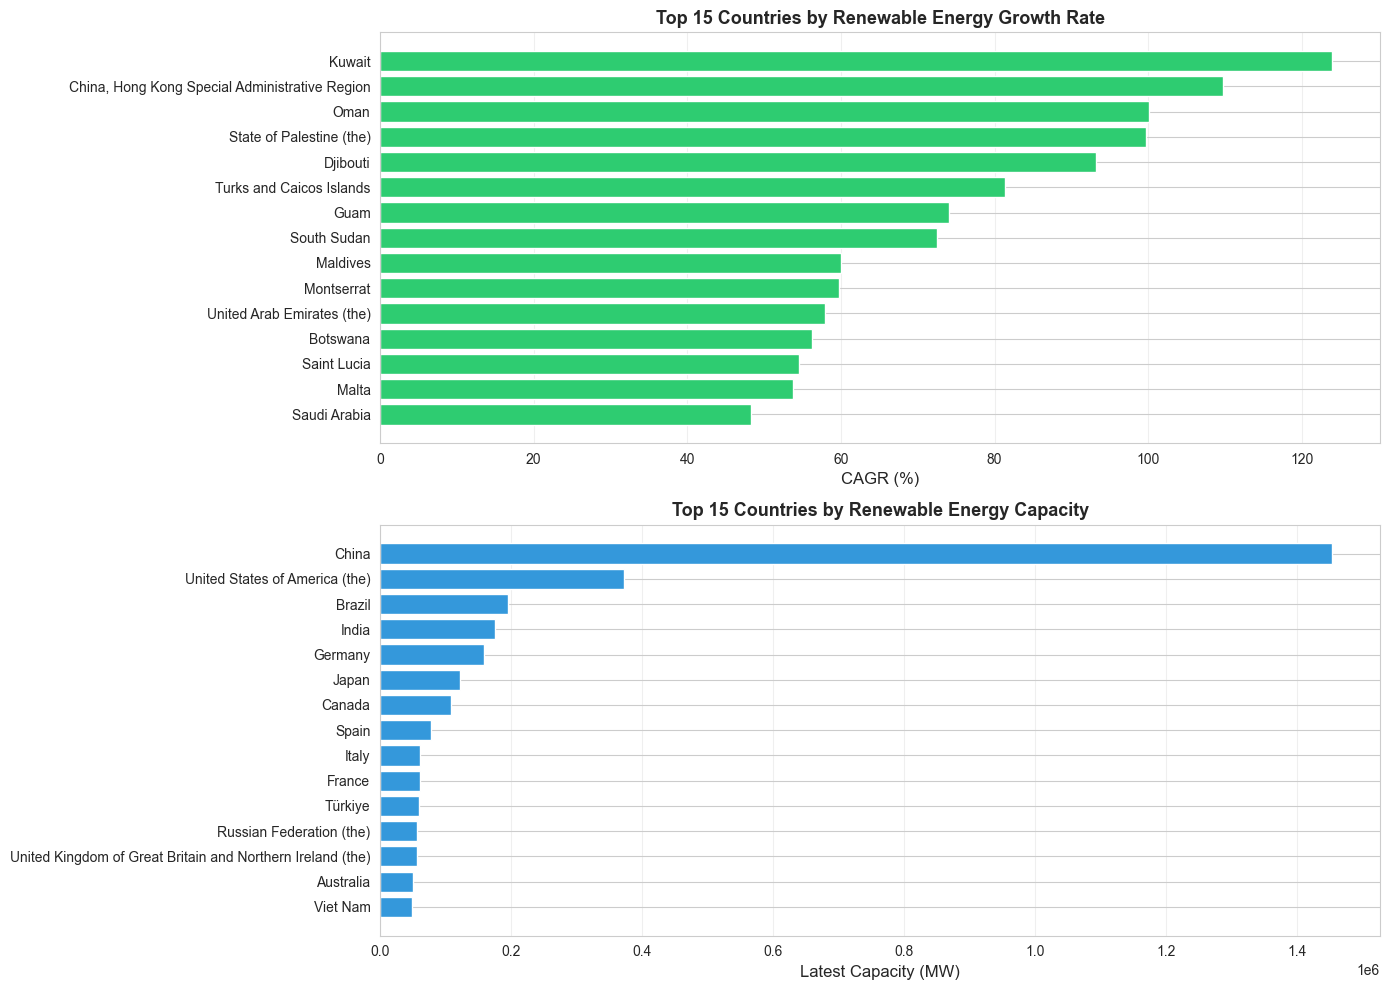

Country analysis visualization saved!


In [18]:
# Country-level growth analysis
country_metrics = []

for country in df_clean['Country'].unique():
    country_data = df_clean[df_clean['Country'] == country].groupby('Year')['Electricity Installed Capacity (MW)'].sum()
    
    if len(country_data) > 1:
        min_year = country_data.index.min()
        max_year = country_data.index.max()
        start_capacity = country_data[min_year]
        end_capacity = country_data[max_year]
        
        years = max_year - min_year
        if start_capacity > 0:
            cagr = ((end_capacity / start_capacity) ** (1 / years) - 1) * 100
            growth_multiple = end_capacity / start_capacity
        else:
            cagr = 0
            growth_multiple = 0
        
        latest_capacity = country_data[max_year]
        
        country_metrics.append({
            'Country': country,
            'CAGR': cagr,
            'Latest_Capacity': latest_capacity,
            'Growth_Multiple': growth_multiple
        })

country_df = pd.DataFrame(country_metrics).sort_values('CAGR', ascending=False)

print("="*80)
print("TOP 20 COUNTRIES BY RENEWABLE ENERGY GROWTH RATE (CAGR)")
print("="*80)
print(country_df.head(20).to_string(index=False))

# Visualize top 15 countries
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top 15 by CAGR
top_cagr = country_df.head(15).sort_values('CAGR')
axes[0].barh(top_cagr['Country'], top_cagr['CAGR'], color='#2ecc71')
axes[0].set_xlabel('CAGR (%)', fontsize=12)
axes[0].set_title('Top 15 Countries by Renewable Energy Growth Rate', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Top 15 by Latest Capacity
top_capacity = country_df.nlargest(15, 'Latest_Capacity').sort_values('Latest_Capacity')
axes[1].barh(top_capacity['Country'], top_capacity['Latest_Capacity'], color='#3498db')
axes[1].set_xlabel('Latest Capacity (MW)', fontsize=12)
axes[1].set_title('Top 15 Countries by Renewable Energy Capacity', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../data/country_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Country analysis visualization saved!")

## 6. Export Forecasting Results

In [19]:
# Save results
metrics_df.to_csv('../data/regional_growth_metrics.csv', index=False)
country_df.to_csv('../data/country_growth_metrics.csv', index=False)
comparison_df.to_csv('../data/model_comparison_results.csv', index=False)

# Create forecast results
forecast_results = pd.DataFrame({
    'Year': future_years.flatten(),
    'Forecast_Capacity_MW': future_pred
})
forecast_results.to_csv('../data/global_capacity_forecast_2025_2029.csv', index=False)

# Summary report
summary_report = f"""
RENEWABLE ENERGY INFRASTRUCTURE GROWTH MONITOR - ANALYSIS SUMMARY
{'='*80}

1. GLOBAL FORECAST (2025-2029)
{'-'*80}
   Model Used: Linear Regression with {lr_model.coef_[0]:,.0f} MW/Year growth trend
   Latest Year Capacity: {y[-1]:,.0f} MW
   Forecast 2029 Capacity: {future_pred[-1]:,.0f} MW
   Expected Growth: {future_pred[-1] - y[-1]:,.0f} MW (5 years)

2. MODEL PERFORMANCE
{'-'*80}
   Best Model: {'Random Forest' if r2_rf > r2_gb else 'Gradient Boosting'}
   Best R² Score: {max(r2_rf, r2_gb):.4f}
   Linear Regression R²: {r2_lr:.4f}

3. REGIONAL GROWTH LEADERS
{'-'*80}
   Top Region: {metrics_df.iloc[0]['Region']} (CAGR: {metrics_df.iloc[0]['CAGR']:.2f}%)
   
4. TOP 5 COUNTRIES BY GROWTH
{'-'*80}
"""

for idx, row in country_df.head(5).iterrows():
    summary_report += f"   {idx+1}. {row['Country']}: {row['CAGR']:.2f}% CAGR, {row['Latest_Capacity']:,.0f} MW\n"

summary_report += f"""
5. KEY INSIGHTS
{'-'*80}
   - Number of Regions Analyzed: {len(metrics_df)}
   - Number of Countries Analyzed: {len(country_df)}
   - Average Regional CAGR: {metrics_df['CAGR'].mean():.2f}%
   - Rapid Growth Regions: {len(rapid_growth)}
   - Steady Growth Regions: {len(steady_growth)}
   - Emerging Regions: {len(emerging)}

{'='*80}
"""

with open('../data/analysis_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("✅ All analysis results exported successfully!")
print(f"\nGenerated Files:")
print(f"  - regional_growth_metrics.csv")
print(f"  - country_growth_metrics.csv")
print(f"  - model_comparison_results.csv")
print(f"  - global_capacity_forecast_2025_2029.csv")
print(f"  - analysis_summary_report.txt")
print(f"\nVisualizations:")
print(f"  - global_forecast_linear.png")
print(f"  - model_comparison.png")
print(f"  - regional_clustering.png")
print(f"  - country_analysis.png")

✅ All analysis results exported successfully!

Generated Files:
  - regional_growth_metrics.csv
  - country_growth_metrics.csv
  - model_comparison_results.csv
  - global_capacity_forecast_2025_2029.csv
  - analysis_summary_report.txt

Visualizations:
  - global_forecast_linear.png
  - model_comparison.png
  - regional_clustering.png
  - country_analysis.png
